In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils, nsd_utils

In [17]:
# Load results of the fitting procedure

subjects = np.arange(1,9)
# subjects = [1,2]
# subjects=[1]
n_subjects = len(subjects)

semantic_discrim_type = 'all_coco_categ_pca'
fitting_type = 'full_midlevel_plus_%s_plus_alexnet_best_layer_pca'%(semantic_discrim_type)

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False) \
       for ss in subjects]
fig_save_folder=None

# initialize roi_def objects to get roi indices
skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois


In [18]:
for ii in range(n_subjects):
    print(out[ii]['voxel_subset_is_done_trn'])

[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]


In [19]:
for ii in range(n_subjects):
    print(out[ii]['voxel_subset_is_done_val'])

[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]


In [30]:
# Load alexnet fit on its own
fitting_type = 'alexnet_best_layer_pca'

out_alexnet_solo = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, verbose=False) \
       for ss in subjects]


leave_out_alexnet


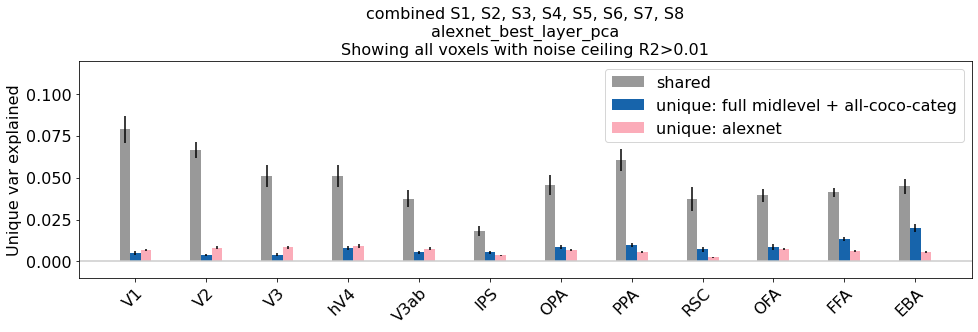

In [37]:
# Make a barplot for variance partition across all ROIs and subjects
roi_names =roi_def.roi_names
nc_thresh = 0.01

print(out[0]['partial_version_names'][6])

name1 = 'full midlevel + all-coco-categ'
name2 = 'alexnet'

ve_names = ['shared', 'unique: ' + name1, 'unique: ' + name2]

gray_color = np.array([[0.6, 0.6, 0.6, 1]])
alexnet_color = cm.RdPu(np.linspace(0,1,4))[1:2,:]
# midlevel_color = cm.BuPu(np.linspace(0,1,6))[4:5,:]
# combined_color = np.array([[0.4, 0.4, 0.4, 1]])
combined_color = cm.Blues(np.linspace(0,1,6))[4:5,:]

colors = np.concatenate([gray_color, combined_color, alexnet_color], axis=0)

vals = np.zeros((n_subjects, n_rois, 3))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']
    val_r2_alexnet_solo = out_alexnet_solo[si]['val_r2'][:,0]
    
    r2_combined = val_r2[:,0]
    r2_a = val_r2[:,6]    
    r2_b = val_r2_alexnet_solo
    
    nc = nsd_utils.ncsnr_to_nc(out[si]['voxel_ncsnr'][out[si]['voxel_mask']])/100
    inds2use = nc>nc_thresh
    
    shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(r2_combined, \
                                                                  r2_a, \
                                                                  r2_b)
    var_expl = np.array([shared_ab, unique_a, unique_b]).T

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with noise ceiling R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, nc_thresh)

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
bw = 0.15;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=space, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.01, 0.12], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=True, legend_separate=False, \
                fig_size=(16,4))

fn2save = '/user_data/mmhender/imStat/figures/variance_partition_midlevel_semantic_alexnet.pdf'
plt.savefig(fn2save)

leave_out_alexnet


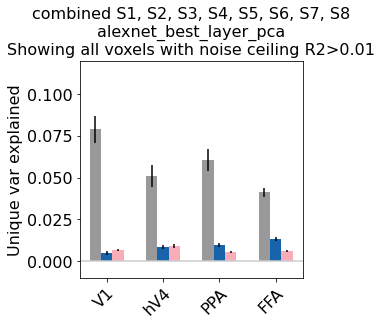

In [45]:
# Make a barplot for variance partition across all ROIs and subjects
roi_names =roi_def.roi_names

rois_plot = [0,3,7,10];

nc_thresh = 0.01

print(out[0]['partial_version_names'][6])

name1 = 'full midlevel + all-coco-categ'
name2 = 'alexnet'

ve_names = ['shared', 'unique: ' + name1, 'unique: ' + name2]

gray_color = np.array([[0.6, 0.6, 0.6, 1]])
alexnet_color = cm.RdPu(np.linspace(0,1,4))[1:2,:]
# midlevel_color = cm.BuPu(np.linspace(0,1,6))[4:5,:]
# combined_color = np.array([[0.4, 0.4, 0.4, 1]])
combined_color = cm.Blues(np.linspace(0,1,6))[4:5,:]

colors = np.concatenate([gray_color, combined_color, alexnet_color], axis=0)

vals = np.zeros((n_subjects, len(rois_plot), 3))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']
    val_r2_alexnet_solo = out_alexnet_solo[si]['val_r2'][:,0]
    
    r2_combined = val_r2[:,0]
    r2_a = val_r2[:,6]    
    r2_b = val_r2_alexnet_solo
    
    nc = nsd_utils.ncsnr_to_nc(out[si]['voxel_ncsnr'][out[si]['voxel_mask']])/100
    inds2use = nc>nc_thresh
    
    shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(r2_combined, \
                                                                  r2_a, \
                                                                  r2_b)
    var_expl = np.array([shared_ab, unique_a, unique_b]).T

    for ri, rr in enumerate(rois_plot):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(rr) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[rr]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with noise ceiling R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, nc_thresh)

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
bw = 0.20;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=space, \
                xticklabels=np.array(roi_names)[rois_plot], ylabel='Unique var explained', \
                ylim=[-0.01, 0.12], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(4,4))

fn2save = '/user_data/mmhender/imStat/figures/variance_partition_midlevel_semantic_alexnet_small.pdf'
plt.savefig(fn2save)

In [21]:
out[0]['partial_version_names']

['full_combined_model',
 'leave_out_gabor_solo',
 'leave_out_pyramid_texture',
 'leave_out_sketch_tokens',
 'leave_out_semantic_coco_things_categ_pca',
 'leave_out_semantic_coco_stuff_categ_pca',
 'leave_out_alexnet']

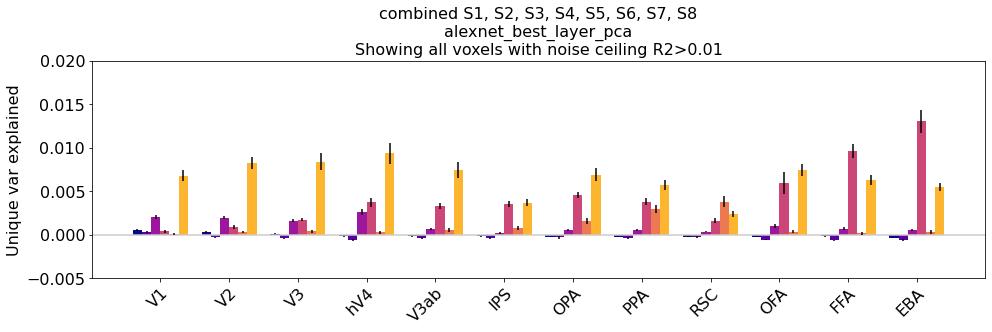

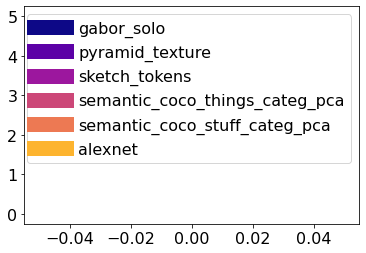

In [46]:
# Make a barplot for variance partition across all ROIs and subjects
roi_names =roi_def.roi_names
nc_thresh = 0.01

# each of these indices is one feature set left out at a time.
ppinds = [1,2,3,4,5,6]
ve_names = [out[0]['partial_version_names'][pp].split('leave_out_')[1] for pp in ppinds]

colors = cm.plasma(np.linspace(0,1,7))[0:6,:]

vals = np.zeros((n_subjects, n_rois, 6))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    nc = nsd_utils.ncsnr_to_nc(out[si]['voxel_ncsnr'][out[si]['voxel_mask']])/100
    inds2use = nc>nc_thresh
    var_expl = np.tile(val_r2[:,0:1], [1,6]) - val_r2[:,ppinds]

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with noise ceiling R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, nc_thresh)

plot_utils.set_all_font_sizes(fs = 16)
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.1, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.005, 0.020], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


In [8]:
# Make a barplot for variance partition across all ROIs and subjects
pp0 = 0
pp1 = 16
pp2 = 15

r2_thresh = 0.01

print(np.array(out[0]['partial_version_names'][pp1]))
print(np.array(out[0]['partial_version_names'][pp2]))
name1 = 'full midlevel + coco categ'
name2 = 'alexnet'


ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

vals = np.zeros((n_subjects, n_rois, 4))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    inds2use = val_r2[:,0]>r2_thresh
    shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], \
                                                                  val_r2[:,pp1], \
                                                                  val_r2[:,pp2])
    var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], \
                           unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        if np.sum(inds_this_roi)==0:
            print('subj %d %s has no voxels'%(ss, roi_names[ri]))
            vals[si,ri,:] = np.nan
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)
        
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh)

plot_utils.set_all_font_sizes(fs = 16)
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=0.3, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.01, 0.20], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

fh = plot_utils.plot_multi_bars(mean_data=mean_vals[:,[1,2]], err_data=sem_vals[:,[1,2]], \
                                colors=colors[[1,2],:], space=0.3, \
                xticklabels=roi_names, ylabel='Unique var explained', \
                ylim=[-0.01, 0.04], title=title, horizontal_line_pos=0,\
                legend_labels=ve_names[1:3], \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))


IndexError: list index out of range

['leave_out_gabor_solo' 'leave_out_pyramid_texture'
 'leave_out_sketch_tokens' 'leave_out_semantic_coco_things_categ'
 'leave_out_semantic_coco_stuff_categ' 'leave_out_alexnet']
[981, 436, 927, 997, 985, 1059]
[96, 641, 150, 80, 92, 18]


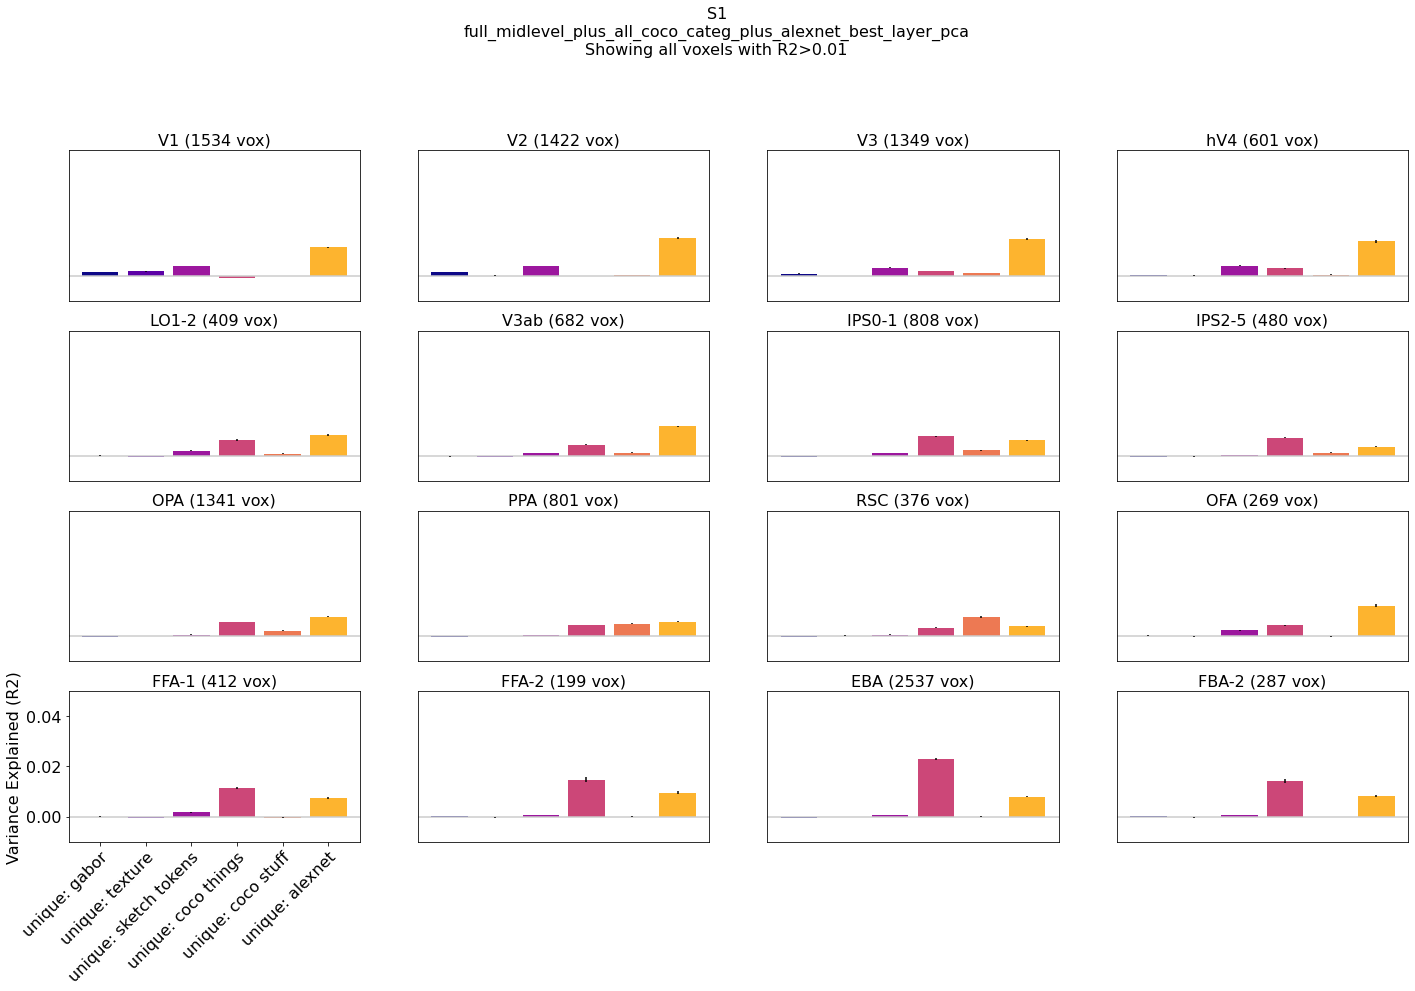

In [19]:

# each of these indices is one feature set left out at a time.
ppinds = [2,4,10,12,14,16]
print(np.array(out[0]['partial_version_names'])[ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==1) for pp in ppinds])
print([np.sum(out[0]['partial_masks'][0][pp,:]==0) for pp in ppinds])
ve_names = ['unique: gabor', 'unique: texture','unique: sketch tokens', \
           'unique: coco things','unique: coco stuff','unique: alexnet']

val_r2 = np.concatenate([o['val_r2'] for o in out], axis=0) 

var_expl = np.tile(val_r2[:,0:1], [1,6]) - val_r2[:,ppinds]

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])

colors = cm.plasma(np.linspace(0,1,7))[0:6,:]
# colors = np.flipud(colors)

r2_thresh = 0.01
inds2use = val_r2[:,0]>r2_thresh

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.05])
plot_utils.create_roi_subplots(var_expl, inds2use, \
                               subject_inds=subject_inds,\
                               single_plot_object=bp, roi_def=roi_def,\
                    suptitle='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh))

plt.gcf().subplots_adjust(bottom=0.4)


leave_out_alexnet
just_alexnet


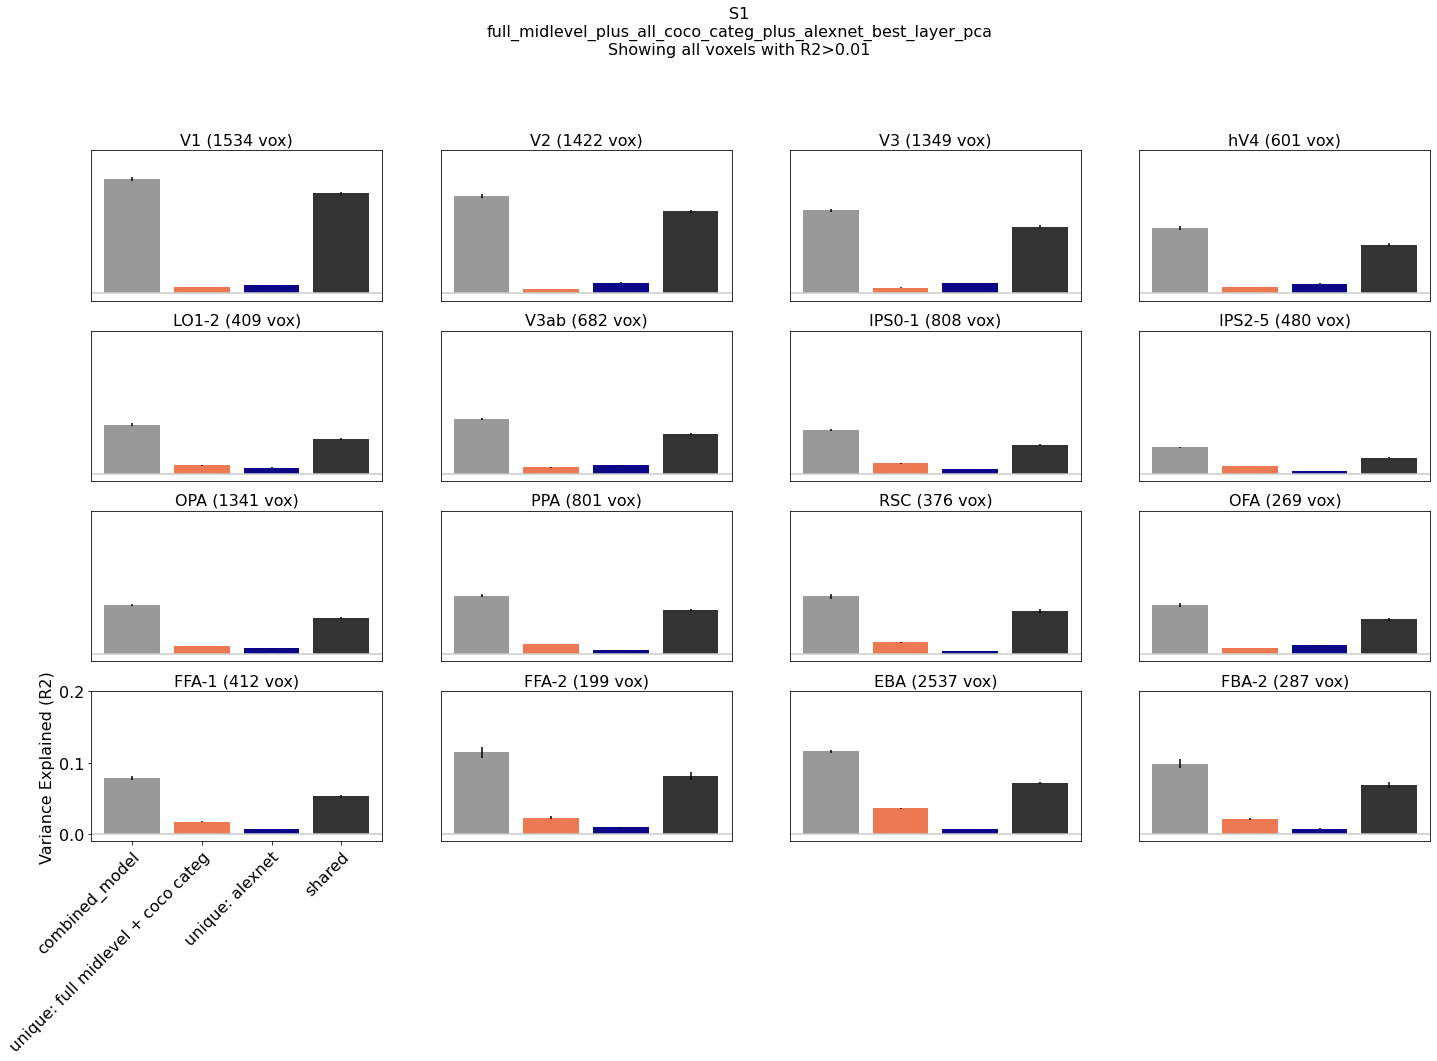

In [20]:
pp0 = 0
pp1 = 16
pp2 = 15

print(np.array(out[0]['partial_version_names'][pp1]))
print(np.array(out[0]['partial_version_names'][pp2]))
name1 = 'full midlevel + coco categ'
name2 = 'alexnet'

val_r2 = np.concatenate([o['val_r2'] for o in out], axis=0) 


ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], \
                                                                  val_r2[:,pp1], \
                                                                  val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], \
                           unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

n_vox = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones(n_vox[si],) for si in range(n_subjects)])


bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.01, 0.20])
plot_utils.create_roi_subplots(var_expl, inds2use, \
                               subject_inds=subject_inds,\
                               single_plot_object=bp, roi_def=roi_def,\
                    suptitle='%s\n%s\nShowing all voxels with R2>%.2f'%(summary_plots.get_substr(out), \
                                                                       fitting_type, r2_thresh))

plt.gcf().subplots_adjust(bottom=0.4)
